>[Importing Libraries](#scrollTo=ZXkr7lOkUKmi)

>[Loading Dataset](#scrollTo=KXnXXj9qT-ss)

>[Model](#scrollTo=HU8O-31wT-sx)

>[Result](#scrollTo=r8fZEPtxT-sy)



# Importing Libraries


In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt
import cv2
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from glob import glob
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A
import keras
import matplotlib.cm as cm
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Loading Dataset

In [2]:
files = ['Normal', 'COVID', 'Lung_Opacity','Viral Pneumonia']
path = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(files):
    for file in os.listdir(os.path.join(data_dir, level+'/'+'images')):
#         data.append(['{}/{}'.format(level, file), level])
        data.append([level +'/' +'images'+ '/'+file, level])


data = pd.DataFrame(data, columns = ['image_file', 'label'])

data['path'] = path + '/' +data['image_file']
data['label'] = data['label'].map({'Normal': 'Normal', 'COVID': 'Covid_positive', 'Lung_Opacity':'Lung_Opacity', 'Viral Pneumonia':'Viral_Pneumonia'})

data.head()


,image_file,label,path
0,Normal/images/Normal-859.png,Normal,../input/covid19-radiography-database/COVID-19...
1,Normal/images/Normal-158.png,Normal,../input/covid19-radiography-database/COVID-19...
2,Normal/images/Normal-10121.png,Normal,../input/covid19-radiography-database/COVID-19...
3,Normal/images/Normal-1811.png,Normal,../input/covid19-radiography-database/COVID-19...
4,Normal/images/Normal-97.png,Normal,../input/covid19-radiography-database/COVID-19...


In [3]:
data.describe()

,image_file,label,path
count,21165,21165,21165
unique,21165,4,21165
top,Normal/images/Normal-859.png,Normal,../input/covid19-radiography-database/COVID-19...
freq,1,10192,1


In [4]:
no_of_samples = 21165
df = pd.DataFrame()
df['label'] = ['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia']
df['Count'] = [len(data[data['label'] == 'Normal']),
               len(data[data['label'] == 'Covid_positive']),
               len(data[data['label'] == 'Lung_Opacity']),
               len(data[data['label'] == 'Viral_Pneumonia'])]
df = df.sort_values(by = ['Count'], ascending = False)

fig = px.bar(df, x = 'label', y = 'Count',
             color = "label",  width = 600,
             color_continuous_scale='BrBg')

fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()

In [5]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((100,100))))

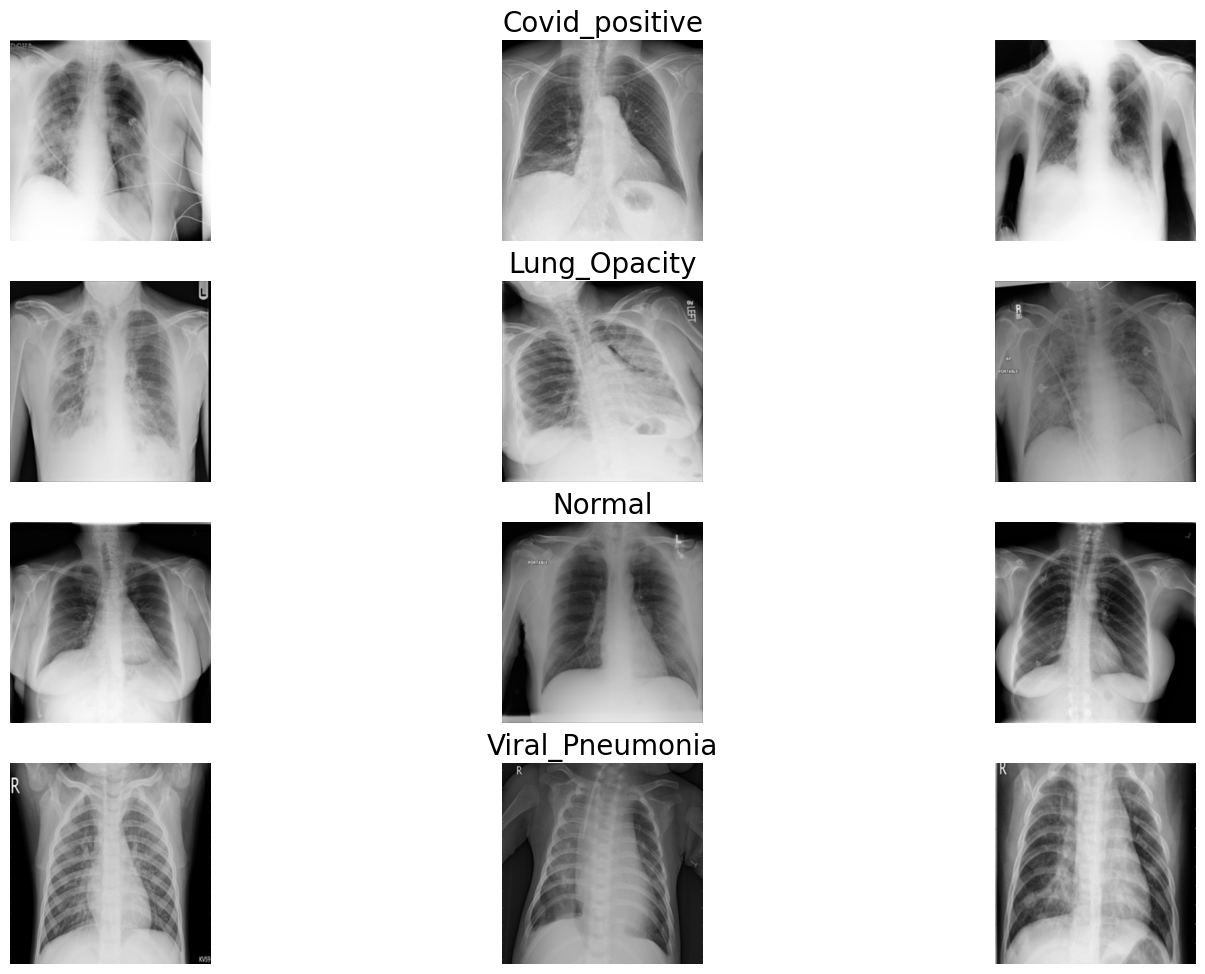

In [6]:
n_samples = 3

fig, m_axs = plt.subplots(4, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['label']).groupby('label')):
    n_axs[1].set_title(type_name, fontsize = 20)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

In [7]:
all_data = []

# Storing images and their labels into a list for further Train Test split
{'Normal': 'Normal', 'COVID': 'Covid_positive', 'Lung_Opacity':'Lung_Opacity', 'Viral Pneumonia':'Viral_Pneumonia'}
for i in range(len(data)):
    image = cv2.imread(data['path'][i], cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale
    image = cv2.resize(image, (100, 100)) / 255.0
    label = 0
    if data['label'][i] == "Normal":
        label = 0
    elif data['label'][i] == "Covid_positive":
        label = 1
    elif data['label'][i] == "Lung_Opacity":
        label = 2
    else:
        label = 3
    all_data.append([image, label])


In [8]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array
x = np.array(x)
y = np.array(y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)


print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(16932, 100, 100) (4233, 100, 100) (16932,) (4233,)


# Model

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(100, 100, 1)))
model.add(layers.BatchNormalization())
##############################
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(layers.BatchNormalization())
model.add(layers.AveragePooling2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(layers.BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
##############################
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(layers.BatchNormalization())
model.add(layers.AveragePooling2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(layers.BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
##############################
model.add(layers.Flatten())

model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))

#Output
model.add(layers.BatchNormalization())
model.add(layers.Dense(4, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 100, 100, 64)     256       
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 50, 50, 64)       0         
 ooling2D)                                                       
                                                        

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



530/530 [==============================] - 594s 1s/step - loss: 0.7385 - accuracy: 0.7307 - val_loss: 1.6677 - val_accuracy: 0.3551
Epoch 2/10
530/530 [==============================] - 589s 1s/step - loss: 0.4837 - accuracy: 0.8192 - val_loss: 0.5080 - val_accuracy: 0.8082
Epoch 3/10
530/530 [==============================] - 591s 1s/step - loss: 0.4058 - accuracy: 0.8464 - val_loss: 2.9534 - val_accuracy: 0.2698
Epoch 4/10
530/530 [==============================] - 592s 1s/step - loss: 0.3647 - accuracy: 0.8604 - val_loss: 0.3695 - val_accuracy: 0.8597
Epoch 5/10
530/530 [==============================] - 591s 1s/step - loss: 0.3332 - accuracy: 0.8764 - val_loss: 0.4699 - val_accuracy: 0.8235
Epoch 6/10
530/530 [==============================] - 591s 1s/step - loss: 0.2982 - accuracy: 0.8899 - val_loss: 0.4806 - val_accuracy: 0.8287
Epoch 7/10
530/530 [==============================] - 591s 1s/step - loss: 0.2730 - accuracy: 0.8990 - val_loss: 0.4644 - val_accuracy: 0.8247
Epoch 8/10

In [12]:
model.save('/kaggle/working/')

# Result

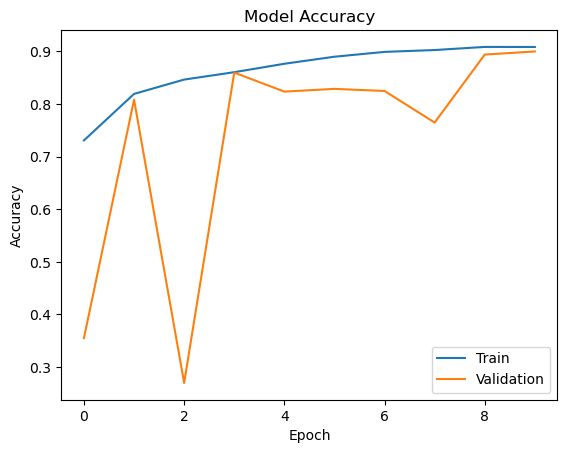

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

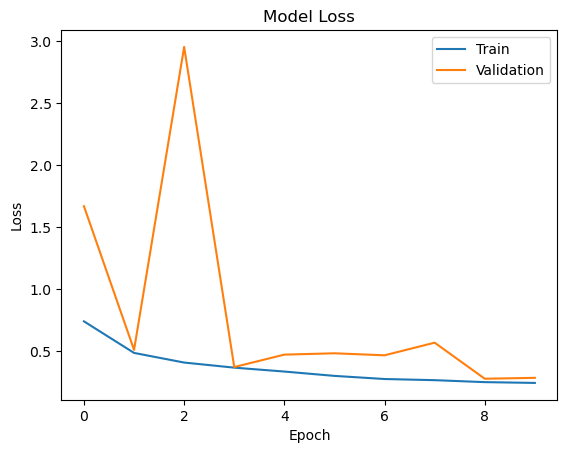

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

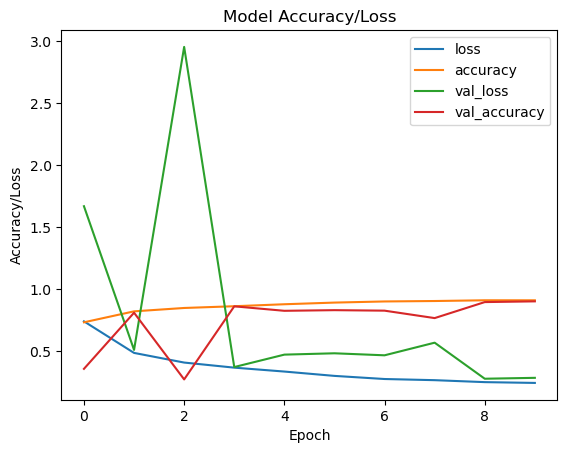

In [15]:
pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

1/1 [==============================] - 0s 69ms/step


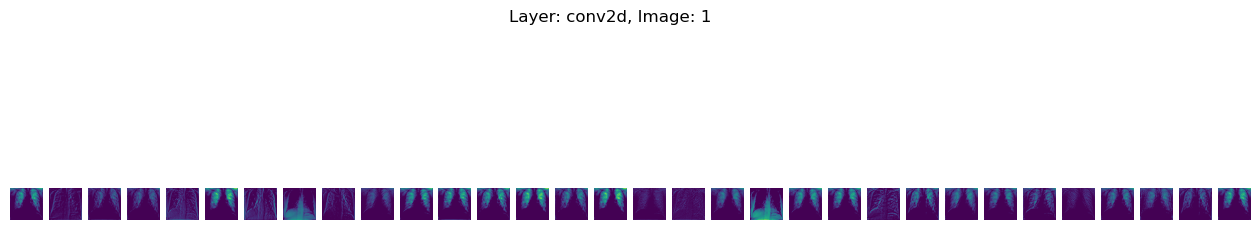

1/1 [==============================] - 0s 18ms/step


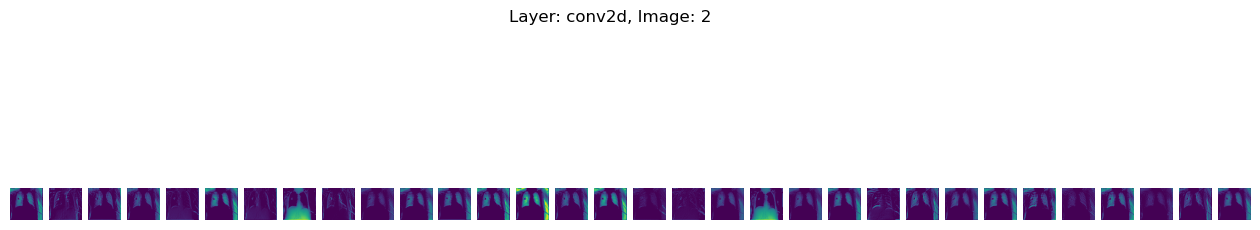

1/1 [==============================] - 0s 60ms/step


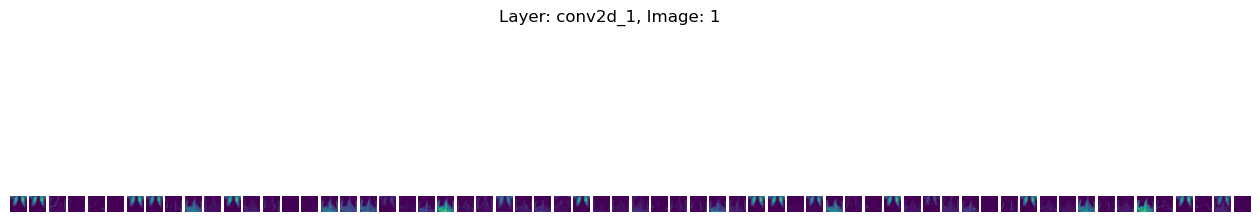

1/1 [==============================] - 0s 28ms/step


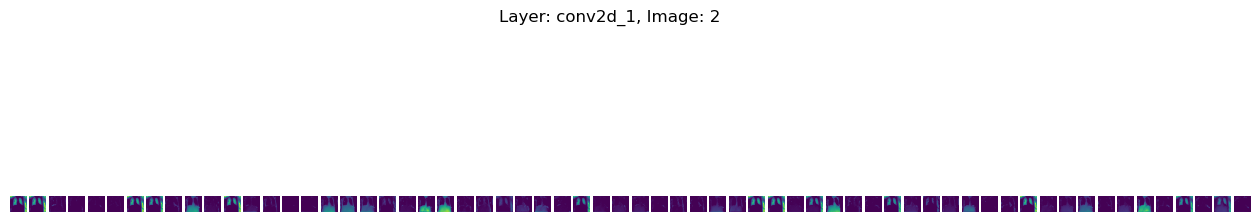

1/1 [==============================] - 0s 73ms/step


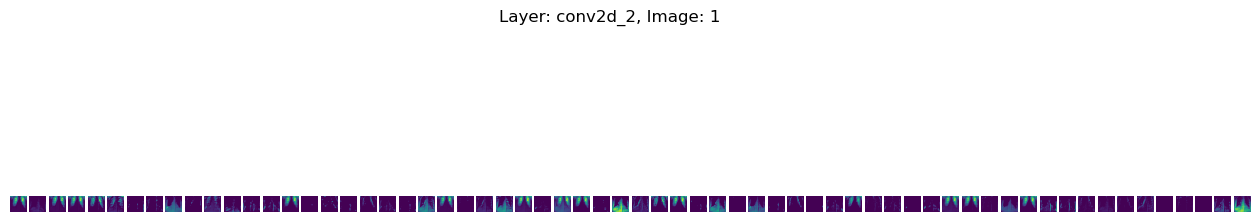

1/1 [==============================] - 0s 26ms/step


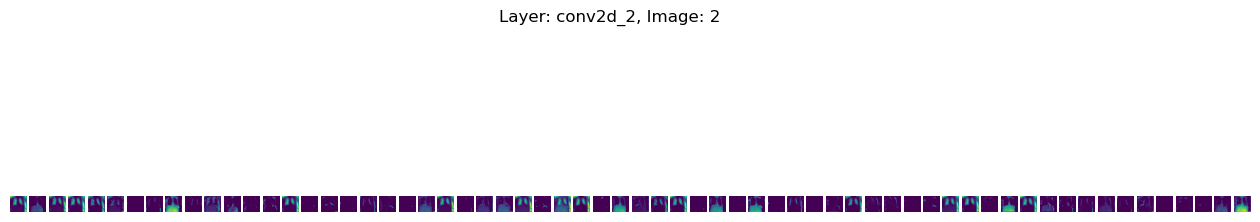

1/1 [==============================] - 0s 84ms/step


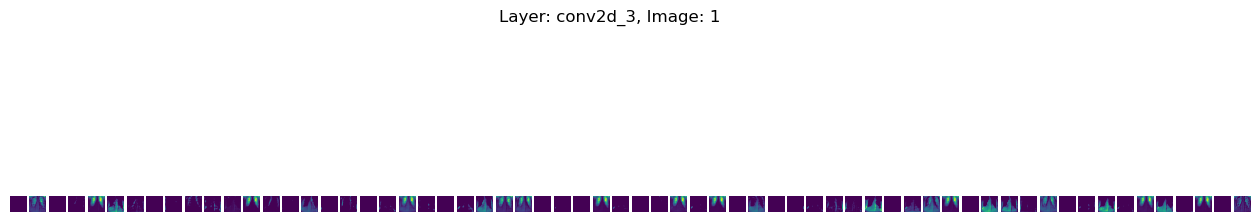

1/1 [==============================] - 0s 26ms/step


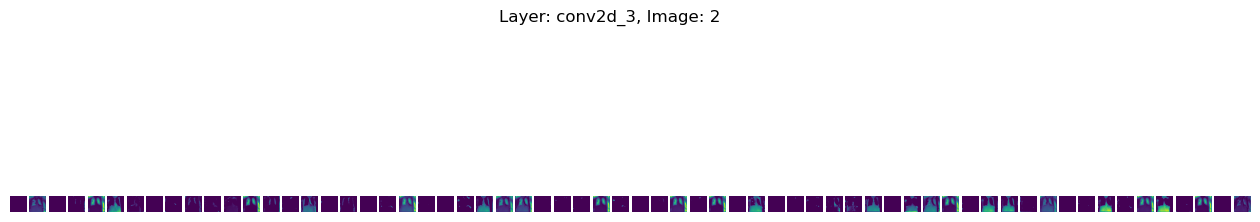

1/1 [==============================] - 0s 101ms/step


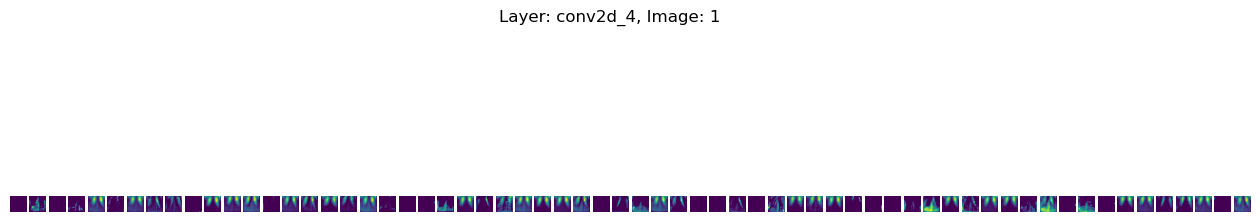

1/1 [==============================] - 0s 26ms/step


In [ ]:

image_paths = ['/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-1020.png',
               '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10001.png'
               ]

images = []
for image_path in image_paths:
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(100, 100), color_mode='grayscale')  # Load as grayscale
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    # Preprocess grayscale image by subtracting the mean for the single channel
    x -= np.mean(x)
    
    images.append(x)

# Loop through all layers and visualize activation maps for each image
for layer in model.layers:
    if 'conv' not in layer.name:
        continue

    layer_name = layer.name
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer.output)

    for idx, img in enumerate(images):
        activations = activation_model.predict(img)
        num_filters = activations.shape[-1]

        plt.figure(figsize=(16, 4))
        for i in range(num_filters):
            plt.subplot(1, num_filters, i+1)
            plt.imshow(activations[0, :, :, i], cmap='viridis')
            plt.axis('off')

        plt.suptitle(f'Layer: {layer_name}, Image: {idx+1}')
        plt.show()


In [32]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image

# Load your pre-trained CNN model
# model = keras.models.load_model('path_to_your_model.h5')  # Replace with the actual path to your model file

# Define class names (modify this list based on your model's classes)

class_names = ["Normal","Covid_positive","Lung_Opacity","Viral Pneumonia"]

def classify_image(image_path):
    try:
        # Load and preprocess the image
        img = Image.open(image_path)
        img = img.resize((100, 100))  # Replace with your image dimensions
        img_array = np.array(img)
        img_array = img_array / 255.0  # Normalize the image data
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions)
        predicted_class = class_names[predicted_class_index]

        return predicted_class

    except Exception as e:
        return str(e)



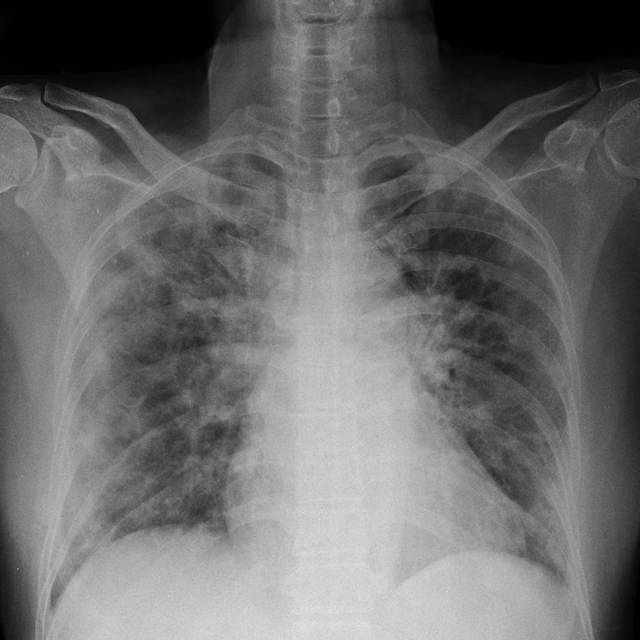

In [46]:

# Example usage:
image_path = '![x-ray-image-2b_full.jpg](attachment:1c78b6f1-13cd-4cf3-9b89-abef79349e52.jpg)'
# Replace with the actual path to your image
predicted_class = classify_image(image_path)
print(f'Predicted class: {predicted_class}')


Predicted class: [Errno 2] No such file or directory: '(attachment:1c78b6f1-13cd-4cf3-9b89-abef79349e52.jpg)'
